# Iron Deficiency in Households with Children in Northern Uganda

In [1]:
# Loading in necessary packages

!pip install -r requirements.txt
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [2]:
#Loading in necessary dataframes

InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [3]:
# Run regression on full dataset

import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

from cfe import Regression

result = Regression(y=y,d=d)
xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]

z = z[rdi.columns.tolist()]
filtered_z = z[(z['F 00-03']!=0) | (z['M 00-03']!=0) | (z['F 04-08']!=0) | (z['M 04-08']!=0)]
filtered_z = filtered_z.xs('2019-20',level='t',drop_level=False)
filtered_z = filtered_z.xs('Northern',level='m',drop_level=False)

filtered_hh_rdi = filtered_z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
filtered_hh_rwi = filtered_hh_rdi*7

use_nutrients = nutrients.columns.intersection(filtered_hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/filtered_hh_rwi[use_nutrients]).dropna()

NameError: name 'y' is not defined

## Introduction:

We are exploring the percentage of Northern Uganda households with children that suffer from iron deficiency, and exploring possible solutions to combat it. We chose iron as a nutrient because a significant amount of households in Northern Uganda with at least one child (0-8 years old) fail to hit the recommended daily amount as shown by the histogram below.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
nutrient_ratio['Iron'].hist(bins=100)
plt.axvline(x = 1, color = 'r', label = 'axvline - full height')

In [ ]:
# Below is the percentage of households with at least one child 0-8 in Northern Uganda that are below recommended iron levels
percent_households_under_rdi = len(nutrient_ratio[nutrient_ratio['Iron']<1])/len(nutrient_ratio['Iron'])
percent_households_under_rdi

## Iron content of beans and millet

Beans (fresh and dry) and millet have significant amounts of iron in them, as shown by the FCT results below

In [ ]:
print(fct[['Iron']].loc['Beans (fresh)'])
print(fct[['Iron']].loc['Beans (dry)'])
print(fct[['Iron']].loc['Millet'])

However, these two products have very different elasticities:

Text(0.5, 0, 'Quantities of Beans Demanded')

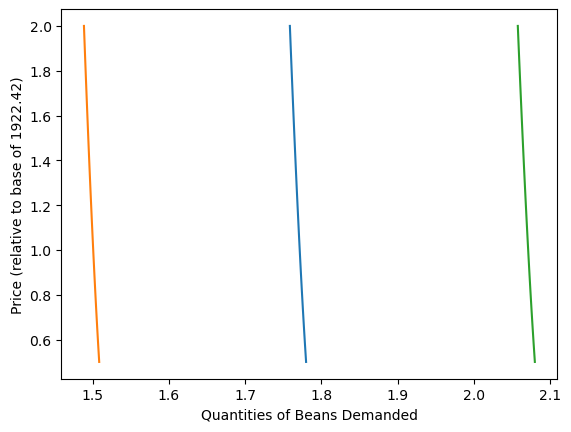

In [6]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median


# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p
pbar


import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beans'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 0, 'Quantities of Beans Demanded')

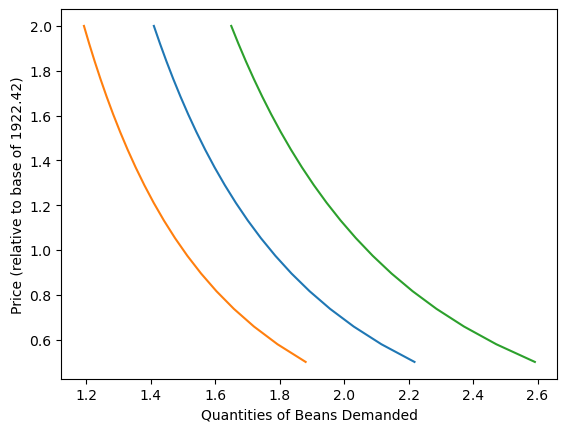

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beans'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

In this project, we will exlore how different policies regarding beans and millet may have different effects on household iron intakes.

## Beans

Beans have a high iron content, and specifically we want to see how much iron intake would change if the iron content of beans were increased, which is what the "iron beans" do. Let's create the same stats as above but with a 30% increase in the iron content of fresh and dry beans.

In [4]:
fct[['Iron']]
#result = sr.replace(to_replace = ['New York', 'Rio'], value = ['London', 'Brisbane'])

n,Iron
j,
Avocado,6.0
Beans (dry),30.0
Beans (fresh),51.0
Beef,19.0
Beef (roasted),27.0
...,...
Tomatoes,3.0
Waragi,0.0
Watermelon,2.4


In [31]:
# If 'n' is the index name, and you want to access the index values, use:
#fct.index.values

In [30]:
def increase_iron_content(fct, food_items, nutrient='Iron', increase_percent=30):
    """
    Increase the iron content of specified food items by a certain percentage.
    
    Parameters:
        fct (DataFrame): The food composition table.
        food_items (list): List of food item names to modify.
        nutrient (str): The nutrient to modify.
        increase_percent (float): The percentage increase.
        
    Returns:
        DataFrame: Updated food composition table with increased nutrient content.
    """
    for food_item in food_items:
        if food_item in fct.index:  # This checks if the food_item exists in the index
            fct.loc[food_item, nutrient] *= (1 + increase_percent / 100)
        else:
            print(f"{food_item} not found in FCT.")
    return fct
# Apply the function to increase iron content by 30% for both dry and fresh beans
updated_fct = increase_iron_content(fct, ['Beans (dry)', 'Beans (fresh)'])

# Display the updated rows for beans to check the changes
updated_fct.loc[['Beans (dry)', 'Beans (fresh)']]

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Beans (dry),1700,98.0,60.0,500,580,325.0,39.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,66.3,11.74,2.12,7.13,0,0.0,4.74,63,23.0


In [11]:
import cfe.regression as rgsn

r = rgsn.read_pickle('uganda_2019-20.pickle')

In [13]:
xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)

In [8]:
def my_prices(p0,p=pbar,j='Beans'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p